## Relation Between Food Cuisines

This notebook follows a 2 phase approach. In the first phase, the Toronto data is analysed. In the second phase, New York data is analysed.

In [125]:
# Basic Packages
import re
import json
import requests

# Packges for Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

pd.set_option('display.max_columns', None)

# Packages for Visualization
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Packages for getting geospatial coordinates
from geopy.geocoders import Nominatim
import geocoder

from sklearn.cluster import KMeans
%matplotlib inline

### Toronto Dataset

Load the data for performing inital analysis with *Toronto Postal Codes Data* found [here](https://github.com/KrishnaChaitanya1/Coursera_Capstone/blob/master/Final%20Capstone%20Project/Data%20Files/Toronto%20Postal%20Codes.csv). The steps taken to get this dataset is clearly explained in [this](https://github.com/KrishnaChaitanya1/Coursera_Capstone/blob/master/Final%20Capstone%20Project/Notebooks/Scraping%20for%20Toronto%20Postal%20Codes.ipynb) notebook. **Change the file path when replicating.**

In [3]:
toronto_df = pd.read_csv(r'..\Data Files\Toronto Postal Codes.csv')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [4]:
toronto_df = toronto_df.sort_values(by = ['PostalCode'], ascending = True).reset_index(drop = True)
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Port Union,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497


Using the geopy package, get the latitude and longitude of the location. The attribute *user_agent* is used in `Nominatim` method in order to remove the warning caused. The latitude and longitude returned is *approximately* correct.

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
toronto_latitude = location.latitude
toronto_longitude = location.longitude

print("The coordinates of Toronto: {}, {}".format(toronto_latitude, toronto_longitude))

The coordinates of Toronto: 43.653963, -79.387207


Using `folium` generate a map for better understanding of the distribution. `zoom_start` attribute is pretty much user preference, it need not be a fixed value. But 10 seems perfect for this map.  
In order to create the popup labels, iterate through the Latitude, Longitude, Borough, Neighborhood and use the `Popup` method of folium to generate the label. Then using the `CircleMarker` method, plot the points on the map. Click on the circle marker to get the location name.

In [9]:
map_toronto = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 10)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_toronto)
    
map_toronto

In a new dataframe store the *Downtown Toronto* borough values. `reset_index` with a drop = True parameter is used in order to generate index starting from 0. 

In [97]:
down_df = toronto_df[toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop = True)
down_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675
2,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675
3,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
4,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636


37 neighborhoods in Downtown Toronto

In [98]:
down_df.shape[0]

37

Get the coordinates of the borough.

In [99]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
down_latitude = location.latitude
down_longitude = location.longitude

print('The coordinates of Downtown Toronto: {}, {}'.format(down_latitude, down_longitude))

The coordinates of Downtown Toronto: 43.655115, -79.380219


Visualize the borough using folium.

In [101]:
map_down = folium.Map(location = [down_latitude, down_longitude], zoom_start = 13)

for lat, lng, neighborhood, borough in zip(down_df['Latitude'], down_df['Longitude'], down_df['Neighborhood'], down_df['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_down)
    
map_down

Use the **Foursquare API** to get the loction data for the particular neighborhood. The credentials are necessary to get the data. **Change the credentials when using** 

In [104]:
down_neighbor_lat = down_df.loc[0, 'Latitude'] # get latitude of first entry
down_neighbor_lng = down_df.loc[0, 'Longitude'] #get longitude of first entry
down_neighbor_name = down_df.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(down_neighbor_lat, 
                       down_neighbor_lng, 
                       down_neighbor_name))

Latitude: 43.6795626, 
Longitude: -79.37752940000001, 
Neighborhood Name: Rosedale


In [105]:
CLIENT_ID = 'BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP' # Change when replicating
CLIENT_SECRET = 'WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY' # Change when replicating
VERSION = '20181204'

print("My Credentials: ")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET: " + CLIENT_SECRET)

My Credentials: 
CLIENT_ID: BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP
CLIENT_SECRET: WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY


Now that we have the CLIENT_ID and CLIENT_SECRET, we can now proceed to generate the url needed for data extraction.

In [106]:
LIMIT = 100
radius = 500

# using the url convention, create the url to get the requests
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    down_neighbor_lat, 
    down_neighbor_lng, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP&client_secret=WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY&v=20181204&ll=43.6795626,-79.37752940000001&radius=500&limit=100'

Now using the `requests` package get the JSON file for the url

In [107]:
down_results = requests.get(url).json() # Get the data in JSON format
down_results

{'meta': {'code': 200, 'requestId': '5c1cf2e4dd579735d5560ef7'},
 'response': {'headerLocation': 'Rosedale',
  'headerFullLocation': 'Rosedale, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.6840626045, 'lng': -79.37131878274371},
   'sw': {'lat': 43.675062595499995, 'lng': -79.38374001725632}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aff2d47f964a520743522e3',
       'name': 'Rosedale Park',
       'location': {'address': '38 Scholfield Ave.',
        'crossStreet': 'at Edgar Ave.',
        'lat': 43.68232820227814,
        'lng': -79.37893434347683,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68232820227814,
          'lng': -79.37893434347683}],
        'distance': 32

Use the below function to get the category types.

In [108]:
def get_category_type(row):
    '''
    Helper code to get the category type
    '''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now let's find the nearby venues for the neighborhood Rosedale.

In [110]:
down_venues = down_results['response']['groups'][0]['items']
down_nearby = json_normalize(down_venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
down_nearby = down_nearby.loc[:, filtered_columns]
down_nearby['venue.categories'] = down_nearby.apply(get_category_type, axis = 1)
down_nearby.columns = [col.split(".")[-1] for col in down_nearby.columns]
down_nearby.head()

,name,categories,lat,lng
0,Rosedale Park,Playground,43.682328,-79.378934
1,Whitney Park,Park,43.682036,-79.373788
2,Alex Murray Parkette,Park,43.678300,-79.382773
3,Milkman's Lane,Trail,43.676352,-79.373842


The below function returns nearby venues for all the neighborhoods. It simply iterates for every neighborhood and generates the url from which the data is extracted and modified for our use.

In [112]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''
    This function returns the nearby venues
    '''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues_down = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues_down.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_down)

In [113]:
down_venues = getNearbyVenues(names=down_df['Neighborhood'],
                                   latitudes=down_df['Latitude'],
                                   longitudes=down_df['Longitude']
                                  )

Rosedale
Cabbagetown
St. James Town
Church and Wellesley
Regent Park
Harbourfront
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide
Richmond
King
Harbourfront East
Union Station
Toronto Islands
Toronto Dominion Centre
Design Exchange
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Kensington Market
Grange Park
Chinatown
King and Spadina
CN Tower
South Niagara
Bathurst Quay
Island airport
Railway Lands
Harbourfront West
Stn A PO Boxes 25 The Esplanade
Underground city
First Canadian Place
Christie


In [162]:
print(down_venues.shape)
down_venues.head()

(2477, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,Cabbagetown,43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [163]:
down_venues.loc[-1] = ['St. James', 43.6709, -79.3733, "Al's Wine", 43.6709, -79.3733, "Bar"]

Onehot Encode the  categories

In [164]:
down_onehot = pd.get_dummies(down_venues[['Venue Category']], prefix = '', prefix_sep = "")

down_onehot['Neighborhood'] = down_venues['Neighborhood']

fixed_columns = [down_onehot.columns[-1]] + list(down_onehot.columns[:-1])
down_onehot = down_onehot[fixed_columns]

down_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [165]:
down_grouped = down_onehot.groupby('Neighborhood').mean().reset_index()
down_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.0,0.000000,0.030000,0.00,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.02,0.000000,0.01,0.020000,0.0,0.0,0.02,0.01,0.00,0.050000,0.00,0.000000,0.00,0.0,0.0,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.020000,0.000000,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02,0.0,0.00,0.01,0.0,0.00,0.01,0.0,0.010000,0.00,0.03,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.01,0.01,0.0,0.0,0.000000,0.02,0.010000,0.00,0.0,0.0,0.0,0.01,0.000000,0.010000,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.000000,0.0,0.01,0.000000,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.02,0.00,0.01,0.0,0.0,0.01,0.000000,0.0,0.01,0.030000,0.0,0.01,0.01,0.00,0.0,0.000000,0.010000,0.0,0.010000,0.0,0.01,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.040000,0.0,0.0,0.02,0.0,0.000000,0.00,0.0,0.000000,0.040000,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.01
1,Bathurst Quay,0.0,0.0,0.0,0.076923,0.076923,0.076923,0.153846,0.153846,0.15

In [166]:
down_grouped_neighbor = down_grouped['Neighborhood'] # Store the neighborhood column in a variable

Store all the column names that end with *Restaurant* as we are interested in this.

In [167]:
down_grouped = down_grouped.loc[:, down_grouped.columns.str.endswith('Restaurant')]
down_grouped.head()

,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0.0,0.04,0.0,0.03,0.000000,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.01,0.000000,0.02,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.030000,0.010000,0.02,0.00,0.040000,0.01,0.0
1,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0
2,0.0,0.00,0.0,0.00,0.018182,0.00,0.00,0.00,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.00,0.018182,0.00,0.036364,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.054545,0.036364,0.00,0.00,0.018182,0.00,0.0
3,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0
4,0.0,0.00,0.0,0.00,0.000000,0.00,0.02,0.02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.04,0.040000,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.080000,0.000000,0.00,0.02,0.020000,0.00,0.0


In [168]:
# Add the neighborhood column
down_grouped['Neighborhood'] = down_grouped_neighbor
down_grouped.head()

,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighborhood
0,0.0,0.04,0.0,0.03,0.000000,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.01,0.000000,0.02,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.030000,0.010000,0.02,0.00,0.040000,0.01,0.0,Adelaide
1,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0,Bathurst Quay
2,0.0,0.00,0.0,0.00,0.018182,0.00,0.00,0.00,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.00,0.018182,0.00,0.036364,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.054545,0.036364,0.00,0.00,0.018182,0.00,0.0,Berczy Park
3,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0,CN Tower
4,0.0,0.00,0.0,0.00,0.000000,0.00,0.02,0.02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.04,0.040000,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.080000,0.000000,0.00,0.02,0.020000,0.00,0.0,Cabbagetown


In [169]:
# Rearrange the neighborhood column to first
cols = list(down_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
down_grouped = down_grouped.loc[:, cols]
down_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Adelaide,0.0,0.04,0.0,0.03,0.000000,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.010000,0.01,0.000000,0.02,0.0,0.01,0.01,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.030000,0.010000,0.02,0.00,0.040000,0.01,0.0
1,Bathurst Quay,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0
2,Berczy Park,0.0,0.00,0.0,0.00,0.018182,0.00,0.00,0.00,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.00,0.018182,0.00,0.036364,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.054545,0.036364,0.00,0.00,0.018182,0.00,0.0
3,CN Tower,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.0
4,Cabbagetown,0.0,0.00,0.0,0.00,0.000000,0.00,0.02,0.02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.04,0.040000,0.02,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.080000,0.000000,0.00,0.02,0.020000,0.00,0.0


Print out the top 5 restaurants in the neighborhoods.

In [170]:
num_top_venues = 5

for hood in down_grouped['Neighborhood']:
    print('------- ' + hood + ' -------')
    temp = down_grouped[down_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue', 'Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------- Adelaide -------
                 Venue  Frequency
0      Thai Restaurant       0.04
1  American Restaurant       0.04
2     Asian Restaurant       0.03
3           Restaurant       0.03
4  Japanese Restaurant       0.02


------- Bathurst Quay -------
                       Venue  Frequency
0          Afghan Restaurant        0.0
1         Italian Restaurant        0.0
2          Korean Restaurant        0.0
3  Latin American Restaurant        0.0
4   Mediterranean Restaurant        0.0


------- Berczy Park -------
                Venue  Frequency
0          Restaurant       0.05
1  Italian Restaurant       0.04
2  Seafood Restaurant       0.04
3     Thai Restaurant       0.02
4  Belgian Restaurant       0.02


------- CN Tower -------
                       Venue  Frequency
0          Afghan Restaurant        0.0
1         Italian Restaurant        0.0
2          Korean Restaurant        0.0
3  Latin American Restaurant        0.0
4   Mediterranean Restaurant        0.0


--

                     Venue  Frequency
0       Italian Restaurant       0.03
1               Restaurant       0.03
2       Chinese Restaurant       0.01
3     Fast Food Restaurant       0.01
4  New American Restaurant       0.01


------- University of Toronto -------
                 Venue  Frequency
0  Japanese Restaurant       0.06
1           Restaurant       0.06
2   Italian Restaurant       0.03
3     Sushi Restaurant       0.03
4   Chinese Restaurant       0.03


------- Victoria Hotel -------
                 Venue  Frequency
0           Restaurant       0.05
1  American Restaurant       0.04
2   Italian Restaurant       0.03
3   Seafood Restaurant       0.03
4      Thai Restaurant       0.02




The below function return most common venues

In [171]:
def return_most_common_venues(row, num_top_venues):
    """
    Returns most common venues
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe based on the top venues

In [172]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
down_restaurants_sorted = pd.DataFrame(columns=columns)
down_restaurants_sorted['Neighborhood'] = down_grouped['Neighborhood']

for ind in np.arange(down_grouped.shape[0]):
    down_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(down_grouped.iloc[ind, :], num_top_venues)

down_restaurants_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Sushi Restaurant,Modern European Restaurant,Vegetarian / Vegan Restaurant,Latin American Restaurant,Mediterranean Restaurant
1,Bathurst Quay,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Doner Restaurant
2,Berczy Park,Restaurant,Seafood Restaurant,Italian Restaurant,French Restaurant,Thai Restaurant,Greek Restaurant,Belgian Restaurant,Comfort Food Restaurant,Doner Restaurant,Filipino Restaurant
3,CN Tower,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Doner Restaurant
4,Cabbagetown,Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Caribbean Restaurant,Chinese Restaurant,Thai Restaurant,Taiwanese Restaurant,Arepa Restaurant,Dumpling Restaurant
5,Central Bay Street,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Falafel Restaurant,Thai Restaurant,Seafood Restaurant,Sushi Restaurant,French Restaurant,Vegetarian / Vegan Restaurant
6,Chinatown,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Dumpling Restaurant,Chinese Restaurant,Caribbean Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Ramen Restaurant,Belgian Restaurant
7,Christie,Italian Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant
8,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Chinese Restaurant
9,Commerce Court,Restaurant,American Restaurant,Seafood Restaurant,Italian Restaurant,Thai Restaurant,French Restaurant,Latin American Restaurant,Asian Restaurant,Gluten-free Restaurant,Greek Restaurant


Using the KMeans method cluster the neighborhood

In [173]:
kclusters = 5

down_grouped_clustering = down_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(down_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 2, 0, 2, 0, 0, 1, 0, 4, 0, 0, 3, 0, 1, 4, 0, 0, 2, 2, 1, 3, 2,
       2, 0, 3, 2, 0, 2, 2, 0, 0, 0, 0, 3, 0, 4, 0])

In [174]:
down_merged = down_df

down_merged['Cluster Labels'] = kmeans.labels_

down_merged = down_merged.join(down_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')

down_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Doner Restaurant
1,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675,2,Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Caribbean Restaurant,Chinese Restaurant,Thai Restaurant,Taiwanese Restaurant,Arepa Restaurant,Dumpling Restaurant
2,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675,0,Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Thai Restaurant,American Restaurant,Seafood Restaurant,Caribbean Restaurant,German Restaurant,Korean Restaurant
3,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2,Sushi Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Mexican Restaurant,American Restaurant,Caribbean Restaurant,Chinese Restaurant
4,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Restaurant,Mexican Restaurant,Greek Restaurant,French Restaurant,Italian Restaurant,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [176]:
map_clusters_down = folium.Map(location = [down_latitude, down_longitude], zoom_start = 13)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(down_merged['Latitude'], down_merged['Longitude'], down_merged['Neighborhood'], down_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_down)
    
map_clusters_down

### New York Dataset

Now that we have completed with Downtown Toronto Data, let's move on to Brooklyn data. This section will be almost similar in steps to that of Downtown Toronto. For performing this analysis, the dataset can be found [here](https://github.com/KrishnaChaitanya1/Coursera_Capstone/blob/master/Final%20Capstone%20Project/Data%20Files/New%20York%20City%20Boroughs.csv). The notebook used to get the dataset is available [here](https://github.com/KrishnaChaitanya1/Coursera_Capstone/blob/master/Final%20Capstone%20Project/Notebooks/Cleaning%20for%20New%20York%20Boroughs.ipynb)

In [177]:
df_nyc = pd.read_csv(r'..\Data Files\New York City Boroughs.csv')
df_nyc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [178]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_nyc = location.latitude
longitude_nyc = location.longitude

print("The coordinates of New York City: {}, {}".format(latitude_nyc, longitude_nyc))

The coordinates of New York City: 40.7308619, -73.9871558


In [180]:
map_nyc = folium.Map(location = [latitude_nyc, longitude_nyc], zoom_start = 10)
for lat, lng, borough, neighborhood in zip(df_nyc['Latitude'], df_nyc['Longitude'], df_nyc['Borough'], df_nyc['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_nyc)
    
map_nyc

Create a new dataset for *Brooklyn* Data values

In [181]:
brook_data = df_nyc[df_nyc['Borough'] == 'Brooklyn'].reset_index(drop = True)
brook_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [182]:
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_brook = location.latitude
longitude_brook = location.longitude
print('The coordinates of Brooklyn: {}, {}'.format(latitude_brook, longitude_brook))

The coordinates of Brooklyn: 40.6501038, -73.9495823


In [185]:
map_brook = folium.Map(location = [latitude_brook, longitude_brook], zoom_start = 11)
for lat, lng, label in zip(brook_data['Latitude'], brook_data['Longitude'], brook_data['Neighborhood']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_brook)
map_brook

Use the **Foursquare API** to get the loction data for the particular neighborhood. The credentials are necessary to get the data. Now that we have already initialized the key values, no need to do so again. 

In [186]:
neighborhood_latitude = brook_data.loc[0, 'Latitude'] # get latitude of first entry
neighborhood_longitude = brook_data.loc[0, 'Longitude'] #get longitude of first entry
neighborhood_name = brook_data.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(neighborhood_latitude, 
                       neighborhood_longitude, 
                       neighborhood_name))

Latitude: 40.625801065010656, 
Longitude: -74.03062069353813, 
Neighborhood Name: Bay Ridge


In [187]:
LIMIT = 100

radius = 500
# using the url convention, create the url to get the requests
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP&client_secret=WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY&v=20181204&ll=40.625801065010656,-74.03062069353813&radius=500&limit=100'

In [188]:
results_brook = requests.get(url).json() # Get the data in JSON format
results_brook

{'meta': {'code': 200, 'requestId': '5c1cfa751ed2194bd4642955'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 91,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatL

In [189]:
brook_venues = results_brook['response']['groups'][0]['items']

brook_nearby = json_normalize(brook_venues) # Flatten the JSON to tabular data

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
brook_nearby = brook_nearby.loc[:, filtered_columns]

brook_nearby['venue.categories'] = brook_nearby.apply(get_category_type, axis = 1)

brook_nearby.columns = [col.split(".")[-1] for col in brook_nearby.columns]
brook_nearby.head()

,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Cocoa Grinder,Juice Bar,40.623967,-74.030863
3,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Ho' Brah Taco Joint,Taco Place,40.622960,-74.031371


In [190]:
brook_venues = getNearbyVenues(names=brook_data['Neighborhood'],
                                   latitudes=brook_data['Latitude'],
                                   longitudes=brook_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [191]:
print(brook_venues.shape)
brook_venues.head()

(2815, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [192]:
brook_onehot = pd.get_dummies(brook_venues[['Venue Category']], prefix = '', prefix_sep = "")

brook_onehot['Neighborhood'] = brook_venues['Neighborhood']

fixed_columns = [brook_onehot.columns[-1]] + list(brook_onehot.columns[:-1])
brook_onehot = brook_onehot[fixed_columns]

brook_onehot.head()

,Yoga Studio,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetaria

In [193]:
brook_grouped = brook_onehot.groupby('Neighborhood').mean().reset_index()
brook_grouped

,Neighborhood,Yoga Studio,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetaria

In [194]:
brook_grouped_neighbor = brook_grouped['Neighborhood']

In [195]:
brook_grouped = brook_grouped.loc[:, brook_grouped.columns.str.endswith('Restaurant')]
brook_grouped.head()

,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0.000000,0.0,0.0,0.020408,0.0,0.020408,0.0,0.061224,0.0,0.000000,0.00000,0.0,0.0,0.0,0.040816,0.0,0.0,0.020408,0.000000,0.0,0.00000,0.000000,0.0,0.040816,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.00000,0.0,0.0,0.0,0.0,0.040816,0.0,0.0,0.0,0.000000,0.0,0.020408,0.0,0.000000
1,0.032967,0.0,0.0,0.000000,0.0,0.000000,0.0,0.021978,0.0,0.010989,0.00000,0.0,0.0,0.0,0.010989,0.0,0.0,0.000000,0.032967,0.0,0.00000,0.010989,0.0,0.065934,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.0,0.0,0.010989,0.000000,0.021978,0.00000,0.0,0.0,0.0,0.0,0.021978,0.0,0.0,0.0,0.021978,0.0,0.000000,0.0,0.010989
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.040000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.093750,0.0,0.000000,0.03125,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.03125,0.000000,0.0,0.062500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.03125,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.031250
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [196]:
brook_grouped['Neighborhood'] = brook_grouped_neighbor
brook_grouped.head()

C:\Users\kchai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighborhood
0,0.000000,0.0,0.0,0.020408,0.0,0.020408,0.0,0.061224,0.0,0.000000,0.00000,0.0,0.0,0.0,0.040816,0.0,0.0,0.020408,0.000000,0.0,0.00000,0.000000,0.0,0.040816,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.00000,0.0,0.0,0.0,0.0,0.040816,0.0,0.0,0.0,0.000000,0.0,0.020408,0.0,0.000000,Bath Beach
1,0.032967,0.0,0.0,0.000000,0.0,0.000000,0.0,0.021978,0.0,0.010989,0.00000,0.0,0.0,0.0,0.010989,0.0,0.0,0.000000,0.032967,0.0,0.00000,0.010989,0.0,0.065934,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.0,0.0,0.010989,0.000000,0.021978,0.00000,0.0,0.0,0.0,0.0,0.021978,0.0,0.0,0.0,0.021978,0.0,0.000000,0.0,0.010989,Bay Ridge
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.040000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,Bedford Stuyvesant
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.093750,0.0,0.000000,0.03125,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.03125,0.000000,0.0,0.062500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.03125,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.031250,Bensonhurst
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,Bergen Beach


In [197]:
cols = list(brook_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
brook_grouped = brook_grouped.loc[:, cols]
brook_grouped.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bath Beach,0.000000,0.0,0.0,0.020408,0.0,0.020408,0.0,0.061224,0.0,0.000000,0.00000,0.0,0.0,0.0,0.040816,0.0,0.0,0.020408,0.000000,0.0,0.00000,0.000000,0.0,0.040816,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020408,0.0,0.0,0.020408,0.020408,0.000000,0.00000,0.0,0.0,0.0,0.0,0.040816,0.0,0.0,0.0,0.000000,0.0,0.020408,0.0,0.000000
1,Bay Ridge,0.032967,0.0,0.0,0.000000,0.0,0.000000,0.0,0.021978,0.0,0.010989,0.00000,0.0,0.0,0.0,0.010989,0.0,0.0,0.000000,0.032967,0.0,0.00000,0.010989,0.0,0.065934,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.0,0.0,0.010989,0.000000,0.021978,0.00000,0.0,0.0,0.0,0.0,0.021978,0.0,0.0,0.0,0.021978,0.0,0.000000,0.0,0.010989
2,Bedford Stuyvesant,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.040000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,Bensonhurst,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.093750,0.0,0.000000,0.03125,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.03125,0.000000,0.0,0.062500,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.03125,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.031250
4,Bergen Beach,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [198]:
num_top_venues = 5

for hood  in brook_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brook_grouped[brook_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.06
1      Sushi Restaurant  0.04
2  Fast Food Restaurant  0.04
3    Italian Restaurant  0.04
4   Peruvian Restaurant  0.02


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.07
1  American Restaurant  0.03
2     Greek Restaurant  0.03
3      Thai Restaurant  0.02
4     Sushi Restaurant  0.02


----Bedford Stuyvesant----
                       venue  freq
0        Japanese Restaurant  0.04
1    New American Restaurant  0.04
2        American Restaurant  0.00
3  Latin American Restaurant  0.00
4   Mediterranean Restaurant  0.00


----Bensonhurst----
                 venue  freq
0   Chinese Restaurant  0.09
1   Italian Restaurant  0.06
2     Sushi Restaurant  0.06
3    Hotpot Restaurant  0.03
4  Dumpling Restaurant  0.03


----Bergen Beach----
                      venue  freq
0       American Restaurant   0.0
1          Arepa Restaurant   0.0
2       Lebanese Restaurant   0.0
3  Mediterran

                       venue  freq
0         Italian Restaurant  0.11
1        American Restaurant  0.00
2  Latin American Restaurant  0.00
3   Mediterranean Restaurant  0.00
4         Mexican Restaurant  0.00


----Manhattan Beach----
                      venue  freq
0       American Restaurant   0.0
1          Arepa Restaurant   0.0
2       Lebanese Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Manhattan Terrace----
                 venue  freq
0  Japanese Restaurant  0.04
1   Chinese Restaurant  0.04
2     Sushi Restaurant  0.04
3           Restaurant  0.04
4   Falafel Restaurant  0.04


----Marine Park----
                      venue  freq
0       American Restaurant   0.0
1          Arepa Restaurant   0.0
2       Lebanese Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Midwood----
                      venue  freq
0  Mediterranean Restaurant  0.07
1        Italian Restaurant  0.07
2        Fal

In [199]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [201]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
brook_restaurants = pd.DataFrame(columns=columns)
brook_restaurants['Neighborhood'] = brook_grouped['Neighborhood']

for ind in np.arange(brook_grouped.shape[0]):
    brook_restaurants.iloc[ind, 1:] = return_most_common_venues(brook_grouped.iloc[ind, :], num_top_venues)

brook_restaurants

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,German Restaurant,Peruvian Restaurant,Restaurant,Russian Restaurant,Cantonese Restaurant,Turkish Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Dim Sum Restaurant,Fast Food Restaurant
2,Bedford Stuyvesant,Japanese Restaurant,New American Restaurant,Vietnamese Restaurant,Kebab Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Dumpling Restaurant,Shabu-Shabu Restaurant,Fast Food Restaurant,Japanese Restaurant,Israeli Restaurant
4,Bergen Beach,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Jewish Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant
5,Boerum Hill,French Restaurant,Middle Eastern Restaurant,American Restaurant,Chinese Restaurant,Indian Restaurant,Halal Restaurant,Mexican Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant
6,Borough Park,Fast Food Restaurant,American Restaurant,Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant
7,Brighton Beach,Restaurant,Eastern European Restaurant,Russian Restaurant,Sushi Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Korean Restaurant,Caribbean Restaurant,Filipino Restaurant,Italian Restaurant
8,Broadway Junction,Caribbean Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Jewish Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant
9,Brooklyn Heights,Italian Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Mexican Restaurant,Ramen Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Indian Restaurant


In [202]:
kclusters = 5

brook_grouped_clustering = brook_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brook_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 4, 2, 1,
       1, 1, 2, 4, 1, 2, 2, 4, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 4, 1, 1, 1, 3, 0, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 4])

In [203]:
brook_merged = brook_data

brook_merged['Cluster Labels'] = kmeans.labels_

brook_merged = brook_merged.join(brook_restaurants.set_index('Neighborhood'), on='Neighborhood')

brook_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,American Restaurant,Greek Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Dim Sum Restaurant,Fast Food Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,0,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Dumpling Restaurant,Shabu-Shabu Restaurant,Fast Food Restaurant,Japanese Restaurant,Israeli Restaurant
2,Brooklyn,Sunset Park,40.645103,-74.010316,1,Latin American Restaurant,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Japanese Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Mexican Restaurant,French Restaurant,Italian Restaurant,New American Restaurant,Polish Restaurant,Vietnamese Restaurant,Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
4,Brooklyn,Gravesend,40.595260,-73.973471,1,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Jewish Restaurant,Japanese Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant


In [204]:
map_clusters_brook = folium.Map(location=[latitude_brook, longitude_brook], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brook_merged['Latitude'], brook_merged['Longitude'], brook_merged['Neighborhood'], brook_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_brook)
       
map_clusters_brook

### Visualizing the Datasets

Let's take a look into the venues once more.

In [206]:
down_restaurants_sorted.head() # Downtown Toronto Venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Thai Restaurant,American Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Sushi Restaurant,Modern European Restaurant,Vegetarian / Vegan Restaurant,Latin American Restaurant,Mediterranean Restaurant
1,Bathurst Quay,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Doner Restaurant
2,Berczy Park,Restaurant,Seafood Restaurant,Italian Restaurant,French Restaurant,Thai Restaurant,Greek Restaurant,Belgian Restaurant,Comfort Food Restaurant,Doner Restaurant,Filipino Restaurant
3,CN Tower,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Doner Restaurant
4,Cabbagetown,Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Caribbean Restaurant,Chinese Restaurant,Thai Restaurant,Taiwanese Restaurant,Arepa Restaurant,Dumpling Restaurant


In [207]:
brook_restaurants.head() # Brooklyn Venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,German Restaurant,Peruvian Restaurant,Restaurant,Russian Restaurant,Cantonese Restaurant,Turkish Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Dim Sum Restaurant,Fast Food Restaurant
2,Bedford Stuyvesant,Japanese Restaurant,New American Restaurant,Vietnamese Restaurant,Kebab Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Dumpling Restaurant,Shabu-Shabu Restaurant,Fast Food Restaurant,Japanese Restaurant,Israeli Restaurant
4,Bergen Beach,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Jewish Restaurant,Japanese Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Halal Restaurant,Greek Restaurant


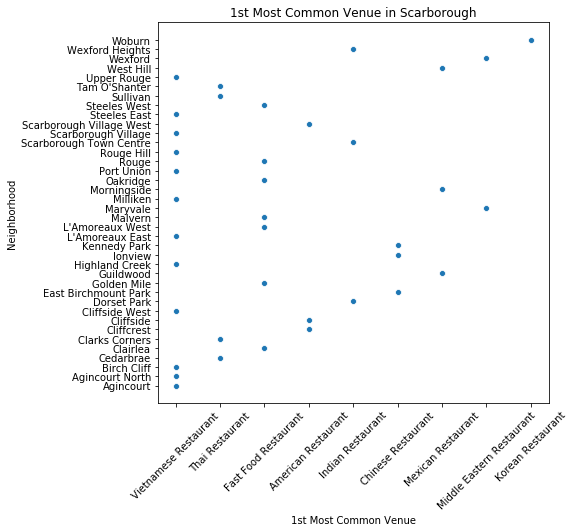

In [88]:
plt.figure(figsize = (7, 7))
sns.scatterplot(x = '1st Most Common Venue', y = 'Neighborhood', 
               data = neighborhoods_venues_sorted_scar)
plt.xticks(rotation = 45)
plt.title('1st Most Common Venue in Scarborough')
plt.show()

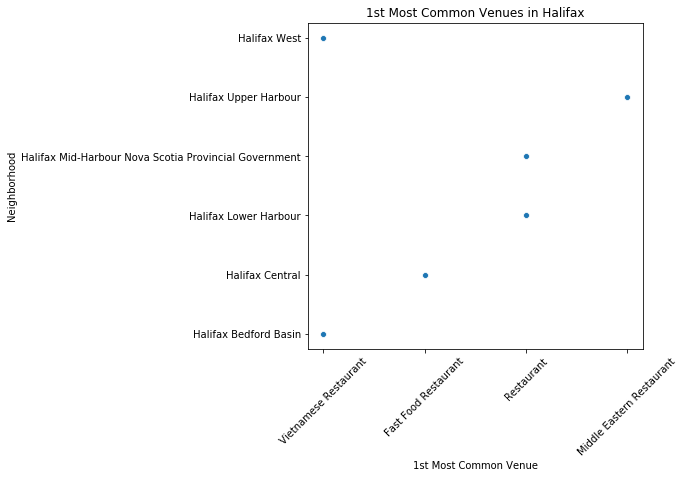

In [85]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = '1st Most Common Venue', y = 'Neighborhood', 
               data = neighborhoods_venues_sorted_hal)
plt.xticks(rotation = 45)
plt.title('1st Most Common Venues in Halifax')
plt.show()